## Load packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

import rasterio as rio
from rasterio.plot import show
import rioxarray as rxr
from rasterio.plot import plotting_extent

import geopandas as gpd
from geopandas import GeoSeries
import osmnx as ox
from osgeo import gdal, osr

from shapely.geometry import mapping
from shapely.geometry import box
from shapely.geometry import Point, LineString
from shapely.geometry.polygon import Polygon
import shapely


import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

from skimage.graph import route_through_array

import networkx as nx
import momepy

import fiona

import pandas as pd

from osgeo import  ogr, gdal, osr, os
import numpy as np
import itertools
from math import sqrt,ceil
from shapely.geometry import shape as shp

import richdem as rd
import folium

import xarray as xr

from xrspatial import a_star_search
from xrspatial.utils import get_dataarray_resolution

import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import geopandas as gpd

import general_file_handling as gfh

import multiprocessing
from joblib import Parallel, delayed
from tqdm.notebook import tqdm, trange

from xrspatial import slope, hillshade
import xarray as xr

import datashader as ds

from datashader.transfer_functions import shade
from datashader.transfer_functions import stack
from datashader.transfer_functions import dynspread
from datashader.transfer_functions import set_background
from datashader.colors import Elevation
import xrspatial

import json
import itertools



C:\Users\hanna\AppData\Local\Temp\ipykernel_22940\1728019391.py:11: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
c:\Users\hanna\Anaconda3\envs\geothings\Lib\site-packages\libpysal\cg\alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit defa

In [2]:
import prepare_raster as pr
import water_roads_graph as wrg
import connecting_nodes as cn
import graph_funcs as gf
from tiler import Tiler, Merger
from matplotlib import image as img
from PIL import Image, ImageEnhance
import numpy as np

In [3]:
import pickle
from collections import Counter
import validation as val
# from json import Point, Feature, FeatureCollection, dump
import json
from collections import defaultdict
from shapely.geometry import box
from geopandas import GeoDataFrame

from shapely import contains



In [4]:
#path of data
pathname = '../Data/dem2/ASTGTMV003_N08W074'

In [5]:
graph_counter_l = 0
graph_counter_s = 0

## Load large network

In [6]:
#get geometry of entire area
#add airstrips of entire area
#connect water and road only at essential points - how?
# or cut into really small pieces and then combine?? or add to large network immediately
#simplification?
#add dense network to small network
# 12.533
# -76.026 -65.391
# 7.711

#1211
#8098
#11170

large_coords = [-76.026, 7.711, -65.391, 12.533]

large_geom = gfh.create_geom(large_coords)

In [7]:
test =False
#to test:
if test == True:
    dem_area, dem_array_area = gfh.read_rast_rasterio(pathname+'_dem.tif')
    if os.path.exists(pathname+'_slope.tif'):
        pass
    else:
        pr.create_slope(pathname+'_dem.tif', pathname+"_slope.tif",  'slope_riserun')
    large_geom = gfh.create_geom(dem_area.bounds)
    large_coords = dem_area.bounds
    large_coords = [large_coords[0],large_coords[1],large_coords[2],large_coords[3]]
    pathname = '../Data/dem/ASTGTMV003_N08W074_test'

In [8]:
#loads water and road graphs for large area, are larger files
if os.path.exists(pathname+'_graph_rl.osm'):
    pass
    print('file exists, file loaded')
else:
    G_rl = ox.graph_from_polygon(large_geom, retain_all=True, truncate_by_edge = True, custom_filter='["highway"~"motorway|trunk|primary|secondary|tertiary|unclassified"]')
    ox.io.save_graphml(G_rl, filepath=pathname+'_graph_rl.osm', encoding='utf-8')
    print('file created')

if os.path.exists(pathname+'_graph_wl.osm'):
    pass
    print('file exists, file loaded')
else:
    G_wl = ox.graph_from_polygon(large_geom, retain_all=True, truncate_by_edge=True, custom_filter='["waterway"~"river|canal|tidal_channel"]')
    ox.io.save_graphml(G_wl, filepath=pathname+'_graph_wl.osm', encoding='utf-8')
    print('file created')

# G = nx.compose(w, r)


file exists, file loaded
file exists, file loaded


In [9]:
#TODO: add commentssss
if os.path.exists(pathname+f'_graph_{graph_counter_l}_l.osm'):
    
    # G_combl = ox.io.load_graphml(filepath=pathname+f'_graph_{graph_counter_l}_l.osm')
    # G_wl = ox.io.load_graphml(filepath=pathname+'_graph_wl_v2.osm')
    # G_rl = ox.io.load_graphml(filepath=pathname+'_graph_rl_v2.osm')
    graph_counter_l+=1
    pass
else:
    G_wl = ox.io.load_graphml(filepath=pathname+'_graph_wl.osm')
    G_rl = ox.io.load_graphml(filepath=pathname+'_graph_rl.osm')

    G_wl = ox.distance.add_edge_lengths(G_wl) #TODO: check with crs??
    G_rl = ox.distance.add_edge_lengths(G_rl)



    nodes_r, edges_r = ox.utils_graph.graph_to_gdfs(G_rl)
    nodes_w, edges_w = ox.utils_graph.graph_to_gdfs(G_wl)
    
    nodes_r['type'] = 'road'
    edges_r['type'] = 'road'

    nodes_w['type'] = 'water'
    edges_w['type'] = 'water'
    nodes_comb = pd.concat([nodes_w, nodes_r])
    edges_comb = pd.concat([edges_w, edges_r])
    nodes_comb.dropna(inplace=True,axis=0,how ='all')
    nodes_comb.drop_duplicates(inplace=True)
    #TODO: check comb graph

    G_combl= ox.utils_graph.graph_from_gdfs(nodes_comb, edges_comb, {'crs': 'EPSG:4326'})
    G_combl.remove_node(8940276086)
    G_combl.remove_node(5144268730)

    #TODO: check crs, from all graphs below
    ox.io.save_graphml(G_combl, filepath=pathname+f'_graph_{graph_counter_l}_l.osm', encoding='utf-8')
    graph_counter_l+=1

        
    G_rl= ox.utils_graph.graph_from_gdfs(nodes_r, edges_r, {'crs': 'EPSG:4326'})
    ox.io.save_graphml(G_rl, filepath=pathname+'_graph_rl_v2.osm', encoding='utf-8')
    G_wl= ox.utils_graph.graph_from_gdfs(nodes_w, edges_w, {'crs': 'EPSG:4326'})
    ox.io.save_graphml(G_wl, filepath=pathname+'_graph_wl_v2.osm', encoding='utf-8')


print(graph_counter_l)

1


### Attach water and roads in large network

In [10]:
#TODO: plot kaartje met water blauw en weg grijs? met bbox erover heen

In [11]:
#create list of geometry seperated into n= 40 smaller bboxes, done to speed up the process
#TODO: creeert nu 49 bboxes ergens gaat nog iets mis? Of misschien restwaardes?
bbox_lst = gfh.clipping_bbox(large_coords, 40)

10.634999999999991 4.821999999999999 1.2455037504961592


10.634999999999991 4.821999999999999 1.2455037504961592
Number of bboxes: 36


C:\Users\hanna\AppData\Local\Temp\ipykernel_22940\2019823246.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


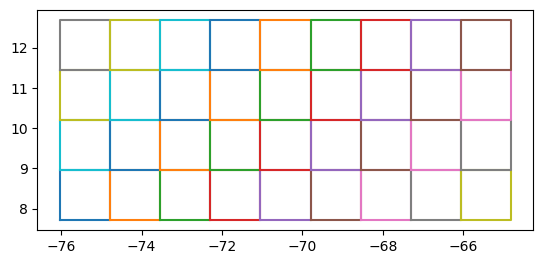

In [12]:
validate =True


if validate == True:
    bbox = large_coords
    fig = val.val_bbox(bbox, 40)
    fig.show()

In [13]:
#TODO: make into validate function
valid=False
if valid == True:
    geom = gfh.create_geom(bbox_lst[8])
    # geom = box(*bbox_lst[8])
    G_r = ox.graph_from_polygon(geom, retain_all=True, truncate_by_edge = True, custom_filter='["highway"~"motorway|trunk|primary|secondary|tertiary|unclassified"]')
    print("contains roads")
    G_w = ox.graph_from_polygon(geom, retain_all=True, truncate_by_edge=True, custom_filter='["waterway"~"river|canal|tidal_channel"]')
    print("contains water")


    a,b,c,d = bbox_lst[8]

    print(geom)
    print(a)
    print(bbox_lst[8])

    G_split = ox.truncate.truncate_graph_bbox(G_wl, d,  b, c, a, truncate_by_edge=True, retain_all=True)
    G_overside =  ox.truncate.truncate_graph_bbox(G_rl, d,  b, c, a, truncate_by_edge=True, retain_all=True)

    nodes_r, edges_r = ox.utils_graph.graph_to_gdfs(G_r)
    nodes_r, edges_r = ox.utils_graph.graph_to_gdfs(G_overside)
    # bbox = bbox_lst[8]
    # print(bbox)



In [14]:
testing = False
if testing == True:
    graph_counter_l +=100
    graph_counter_s +=100

In [15]:
validate = False
if validate == True:
    count = 0
    #list to save nodes that are not connected
    not_connected = []

    #TODO: these need to be saved as well?
    G_wl = ox.io.load_graphml(filepath=pathname+'_graph_wl_v2.osm')
    G_rl = ox.io.load_graphml(filepath=pathname+'_graph_rl_v2.osm')

    # for bbox in tqdm(bbox_lst):
    print(graph_counter_l)
    #TODO: change for if testing is true
    graph_counter_l_prev =graph_counter_l-1
    G_wrl_cnct = ox.io.load_graphml(filepath=pathname+f'_graph_{graph_counter_l_prev}_l.osm')
    edge_lst = []
    nodes_added = defaultdict(list)
    #TODO: check if this works
    a,b,c,d = bbox_lst[1]



    G_split = ox.truncate.truncate_graph_bbox(G_wl, d,  b, c, a, truncate_by_edge=True, retain_all=True)
        
    G_overside =  ox.truncate.truncate_graph_bbox(G_rl, d,  b, c, a, truncate_by_edge=True, retain_all=True)
    G_wrl_cnct =  ox.truncate.truncate_graph_bbox(G_wrl_cnct, d,  b, c, a, truncate_by_edge=True, retain_all=True)



    
    
    G_wrl_cnct = G_wrl_cnct.copy()
    nodes_r, edges_r = ox.utils_graph.graph_to_gdfs(G_overside)
    nodes_r.drop_duplicates(inplace=True)



    # nodes_w, edges_w = ox.utils_graph.graph_to_gdfs(G_split)

    #removes all edges from road network that are in nodelist
    #needed for overside function, to prevent nearest road from being a road that is already added through the nodelst
    nodes_r_lst = []

    for i in nodes_r.index:
        nodes_r_lst.append({'x_start': nodes_r.loc[i]['geometry'].x, 
                            'y_start': nodes_r.loc[i]['geometry'].y,
                            'x_goal': nodes_r.loc[i]['geometry'].x, 
                            'y_goal': nodes_r.loc[i]['geometry'].y,
                            'u': i,
                            'type': 'road',
                            'goal_id': 0})
        
    G_split, G_wrl_cnct, nodes_edgelst, nodes_bbox = wrg.connecting(G_split, G_wrl_cnct, pathname+f'_graph_split{count}_l_valid.osm', pathname+f'_graph_temp{count}_l_valid.osm', nodes_r_lst, "water_road", "water", distance_limit = 500, waterpth = pathname+f'{count}_valid')
    nodes_added[f'{bbox}'] = nodes_bbox
    edge_lst.append(nodes_edgelst)
    count+=1

    for el in edge_lst:
        for e in el:
            try:
                G_rl.remove_node(e)
            except:
                pass




        #create subsection of water and road graph
        
    G_overside =  ox.truncate.truncate_graph_bbox(G_rl, d,  b, c, a, truncate_by_edge=True, retain_all=True)
    
    G_wrl_cnct = G_wrl_cnct.copy()
    nodes_r, edges_r = ox.utils_graph.graph_to_gdfs(G_overside)


    #TODO: change into wrg.connecting
    nodes_r_lst = []

    for i in nodes_r.index:
        nodes_r_lst.append({'x_start': nodes_r.loc[i]['geometry'].x, 
                            'y_start': nodes_r.loc[i]['geometry'].y,
                            'x_goal': nodes_r.loc[i]['geometry'].x, 
                            'y_goal': nodes_r.loc[i]['geometry'].y,
                            'u': i,
                            'type': 'road',
                            'goal_id': 0})
    G_split, G_wrl_cnct, nodes_edgelst, nodes_bbox = wrg.connecting(G_split, G_wrl_cnct, pathname+f'_graph_split{count}_s_valid2.osm', pathname+f'_graph_temp{count}_s_valid2.osm', nodes_r_lst, "water_road_overside", "water", distance_limit = 500, waterpth = pathname+f'{count}_valid')








In [ ]:
#TODO: get_potential_overside could maybe be replaced by create_crossing
#TODO: for some reason there is very little input?
#eerste 18 zijn
count=0

if os.path.exists(pathname+f'_graph_{graph_counter_l}_l.osm'):
    # G_w_split = ox.io.load_graphml(filepath=pathname+'_graph_w_split.osm')
    # G_r_split = ox.io.load_graphml(filepath=pathname+'_graph_r_split.osm')
    # G_wrl_cnct =  ox.io.load_graphml(filepath=pathname+f'_graph_{graph_counter_l}_l.osm')
    graph_counter_l+=1
    pass
else:
#list to save nodes that are not connected
    not_connected = []

    #TODO: these need to be saved as well?
    G_wl = ox.io.load_graphml(filepath=pathname+'_graph_wl_v2.osm')
    G_rl = ox.io.load_graphml(filepath=pathname+'_graph_rl_v2.osm')

    # for bbox in tqdm(bbox_lst):
    print(graph_counter_l)
    #TODO: change for if testing is true
    graph_counter_l_prev =graph_counter_l-1
    G_wrl_cnct = ox.io.load_graphml(filepath=pathname+f'_graph_{graph_counter_l_prev}_l.osm')
    edge_lst = []
    nodes_added = defaultdict(list)
    #TODO: check if this works
    print('graph loaded')
    # small_coords = [-73.10001388888889,8.5, -72.99986111111112, 8.60013888888889]
    # a,b,c,d = small_coords

    # G_wrl_cnct = ox.truncate.truncate_graph_bbox(G_wrl_cnct,d,  b, c, a, truncate_by_edge=False, retain_all=True)
    # print('clipped')
    # G_wl =  ox.truncate.truncate_graph_bbox(G_wl, d,  b, c, a, truncate_by_edge=False, retain_all=True)
    # print('clipped 2')
    # G_rl =  ox.truncate.truncate_graph_bbox(G_rl, d,  b, c, a, truncate_by_edge=False, retain_all=True)
    # print('graph clipped')

    for bbox in tqdm(bbox_lst) :
            # if count>1:
            #         break
                # print(bbox)
            a,b,c,d = bbox

            print(bbox)
            
            water_nodes = gf.get_nodes_wth_attr(G_wrl_cnct, 'type', 'water')
            G_wl = G_wrl_cnct.subgraph(water_nodes)
            

            try:
                G_split = ox.truncate.truncate_graph_bbox(G_wl, d,  b, c, a, truncate_by_edge=True, retain_all=True)
                G_overside =  ox.truncate.truncate_graph_bbox(G_rl, d,  b, c, a, truncate_by_edge=True, retain_all=True)
                print('split')
            except:
                 print(count)
                 count+=1
                 continue


            
            
            G_wrl_cnct = G_wrl_cnct.copy()
            nodes_r, edges_r = ox.utils_graph.graph_to_gdfs(G_overside)
            nodes_r.drop_duplicates(inplace=True)



            # nodes_w, edges_w = ox.utils_graph.graph_to_gdfs(G_split)

            #removes all edges from road network that are in nodelist
            #needed for overside function, to prevent nearest road from being a road that is already added through the nodelst
            nodes_r_lst = []

            for i in nodes_r.index:
                nodes_r_lst.append({'x_start': nodes_r.loc[i]['geometry'].x, 
                                    'y_start': nodes_r.loc[i]['geometry'].y,
                                    'x_goal': nodes_r.loc[i]['geometry'].x, 
                                    'y_goal': nodes_r.loc[i]['geometry'].y,
                                    'u': i,
                                    'type': 'road',
                                    'goal_id': 0})
                
            G_split, G_wrl_cnct, nodes_edgelst, nodes_bbox = wrg.connecting(G_split, G_wrl_cnct, pathname+f'_graph_split{count}_l.osm', pathname+f'_graph_temp{count}_l.osm', nodes_r_lst, "water_road", "water", distance_limit = 500, waterpth = pathname+f'{count}', constructing_phase="water_road")
            nodes_added[f'{bbox}'] = nodes_bbox
            edge_lst.append(nodes_edgelst)
            count+=1





    with open(pathname+f'_oversides.pk','wb') as f:
        pickle.dump(nodes_added, f)
    with open(pathname+f'_water_road.pk','wb') as f:
        pickle.dump(edge_lst, f)


    ox.io.save_graphml(G_split, filepath=pathname+'_graph_w_split.osm', encoding='utf-8')
    ox.io.save_graphml(G_wrl_cnct, filepath=pathname+f'_graph_{graph_counter_l}_l.osm', encoding='utf-8')
    
    graph_counter_l+=1
    G_split = None
    G_overside = None
    G_wrl_cnct = None


    # G_w_split = G_split
    # G_r_split = G_overside




In [ ]:

#TODO: remove graphg from files!!!

if os.path.exists(pathname+f'_graph_{graph_counter_l}_l.osm'):
    # G_w_split = ox.io.load_graphml(filepath=pathname+'_graph_w_split.osm')
    # G_r_split = ox.io.load_graphml(filepath=pathname+'_graph_r_split.osm')
    # G_wrl_cnct =  ox.io.load_graphml(filepath=pathname+f'_graph_{graph_counter_l}_l.osm')
    print(graph_counter_l)
    graph_counter_l+=1
    pass
else:
    #list to save nodes that are not connected
    not_connected = []

    # for bbox in tqdm(bbox_lst):
    count=0
    print(graph_counter_l, 'hi')
    graph_counter_l_prev =graph_counter_l-1
    G_wrl_cnct = ox.io.load_graphml(filepath=pathname+f'_graph_{graph_counter_l_prev}_l.osm')
    G_rl = ox.io.load_graphml(filepath=pathname+'_graph_rl_v2.osm')

    
    # a,b,c,d = small_coords

    # G_rl =  ox.truncate.truncate_graph_bbox(G_rl, d,  b, c, a, truncate_by_edge=False, retain_all=True)

    nodes_r, edges_r = ox.utils_graph.graph_to_gdfs(G_wrl_cnct)



    with open(pathname+f'_oversides.pk','rb') as f:
        nodes_added = pickle.load(f)
    with open(pathname+f'_water_road.pk','rb') as f:
        edge_lst = pickle.load(f)

    #removes nodes from roads that are already connected to water
    for el in edge_lst:
        for e in el:
            try:
                G_rl.remove_node(e)
            except:
                pass
        



    for bbox in tqdm(bbox_lst):
        # if os.path.exists(pathname+f'_graph_{graph_counter_l_prev}_l.osm'):
        #     count+=1
            
        #     G_wrl_cnct = ox.io.load_graphml(filepath=pathname+f'_graph_{graph_counter_l_prev}_l.osm')
        #     continue

        a,b,c,d = bbox

        #create subsection of water and road graph
        try:
            G_split =  ox.truncate.truncate_graph_bbox(G_rl, d,  b, c, a, truncate_by_edge=True, retain_all=True)
            G_overside =  ox.truncate.truncate_graph_bbox(G_wrl_cnct, d,  b, c, a, truncate_by_edge=True, retain_all=True)
        except:
            continue

        G_wrl_cnct = G_wrl_cnct.copy()

        #TODO: change into wrg.connecting
        nodes_r_lst = []

        edges = gf.get_edges_wth_attr(G_overside, 'type', 'water_road')
        print(len(edges))

        nodes_added = []
        for u,v,i in edges:
            if G_overside.nodes[v]['type'] == 'water':
                nodes_added.append(v)
            if G_overside.nodes[u]['type'] == 'water' :
                nodes_added.append(u)

        for i in nodes_added:
                nodes_r_lst.append({'x_start': nodes_r.loc[i]['geometry'].x, 
                                    'y_start': nodes_r.loc[i]['geometry'].y,
                                    'x_goal': nodes_r.loc[i]['geometry'].x, 
                                    'y_goal': nodes_r.loc[i]['geometry'].y,
                                    'u': i,
                                    'type': 'road',
                                    'goal_id': 0})
        G_split, G_wrl_cnct, nodes_edgelst, nodes_bbox = wrg.connecting(G_split, G_wrl_cnct, pathname+f'_graph_split{count}_s.osm', pathname+f'_graph_temp{count}_s.osm', nodes_r_lst, "water_road_overside", "water", distance_limit = 500, waterpth = pathname+f'{count},  constructing_phase="water_road_overside")')
                
        count+=1




    # ox.io.save_graphml(G_split, filepath=pathname+'_graph_w_split.osm', encoding='utf-8')
    # ox.io.save_graphml(G_overside, filepath=pathname+'_graph_r_split.osm', encoding='utf-8')
    ox.io.save_graphml(G_wrl_cnct, filepath=pathname+f'_graph_{graph_counter_l}_l.osm', encoding='utf-8')
    
    graph_counter_l+=1
    G_split = None
    G_overside = None
    G_wrl_cnct = None


    # G_w_split = G_split
    # G_r_split = G_overside




2


In [18]:
print(graph_counter_l)

3


In [19]:
validate = True
if validate == True:
    graph_counter_l_prev =2
    G_wrl_cnct = ox.io.load_graphml(filepath=pathname+f'_graph_{graph_counter_l_prev}_l.osm')

    #TODO: why node type water_road as well?
    print(val.validate_edge_attr(G_wrl_cnct, 'type'))
    print(val.validate_node_attr(G_wrl_cnct, 'type'))

Counter({'road': 163059, 'water': 20950, 'water_road': 16511, 'water_road_overside': 538})
Counter({'road': 80029, 'water': 15803, 'water_road': 2099, 'water_road_overside': 116})


In [20]:
validate = True
if validate == True:
    
    graph_counter_l_prev =1
    G_wrl_cnct = ox.io.load_graphml(filepath=pathname+f'_graph_{graph_counter_l_prev}_l.osm')

    #TODO: why node type water_road as well?
    print(val.validate_edge_attr(G_wrl_cnct, 'type'))
    print(val.validate_node_attr(G_wrl_cnct, 'type'))

Counter({'road': 162814, 'water': 20955, 'water_road': 16511})
Counter({'road': 79788, 'water': 15840, 'water_road': 2099})


In [21]:
# if os.path.exists(pathname+f'_nc'):
#         with open(pathname+f'_nc','rb') as f:
#             not_connected = pickle.load(f)
# else:
#     with open(pathname+f'_nc','wb') as f:
#         pickle.dump(not_connected, f)

In [22]:
# G = nx.compose(G_w_split, G_r_split)
# nodes, edges = ox.utils_graph.graph_to_gdfs(G)
# nodes_edges = pd.concat([nodes.reset_index(), edges.reset_index()])

In [23]:
if os.path.exists(pathname+f'_graph_{graph_counter_l}_l.osm'):
    # G_w_split = ox.io.load_graphml(filepath=pathname+'_graph_w_split.osm')
    # G_r_split = ox.io.load_graphml(filepath=pathname+'_graph_r_split.osm')
    # G_wrl_cnct =  ox.io.load_graphml(filepath=pathname+f'_graph_{graph_counter_l}_l.osm')
    print(graph_counter_l)
    graph_counter_l+=1
    pass
else:
    graph_counter_l_prev =graph_counter_l - 1
    G_wrl_cnct = ox.io.load_graphml(filepath=pathname+f'_graph_{graph_counter_l_prev}_l.osm')
    G_wrl_un = G_wrl_cnct.to_undirected(reciprocal=False, as_view=False)
    a = [c for c in sorted(nx.connected_components(G_wrl_un), key=len, reverse=True)]
    S0 = G_wrl_cnct.subgraph(a[0]).copy()
    ox.io.save_graphml(S0, filepath=pathname+f'_graph_{graph_counter_l}_l.osm', encoding='utf-8')
    graph_counter_l+=1



3


## Load raster

In [24]:
if test == True:
    pathname = '../Data/dem2/ASTGTMV003_N08W074'

dem_area, dem_array_area = gfh.read_rast_rasterio(pathname+'_dem.tif')
if os.path.exists(pathname+'_slope.tif'):
    pass
else:
    pr.create_slope(pathname+'_dem.tif', pathname+"_slope.tif",  'slope_riserun')

In [25]:
geom_area = gfh.create_geom(dem_area.bounds)

In [26]:
dem_area.bounds

BoundingBox(left=-74.0001388888889, bottom=7.999861111111111, right=-72.99986111111112, top=9.00013888888889)

In [27]:
geoj = shapely.to_geojson(large_geom)

In [28]:
with open('myfile.geojson', 'w') as f:
   json.dump(geoj, f)

In [29]:
if test == True:
    geom_small = gfh.create_geom(rio.coords.BoundingBox(dem_area.bounds[0],dem_area.bounds[1],dem_area.bounds[0]+0.4, dem_area.bounds[1]+0.4))
    raster = rxr.open_rasterio(pathname+'_dem.tif')
    pathname = '../Data/dem/ASTGTMV003_N08W074'
    clipped_raster = raster.rio.clip([geom_small])
    
    # Save clipped raster
    path_to_tif_file = pathname + "_clipped_test_dem.tif"

    clipped_raster.rio.to_raster(path_to_tif_file)
    pathname = '../Data/dem/ASTGTMV003_N08W074_clipped_test'
    pathname+'_dem.tif'

    dem_area, dem_array_area = gfh.read_rast_rasterio(pathname+'_dem.tif')
    if os.path.exists(pathname+'_slope.tif'):
        pass
    else:
        pr.create_slope(pathname+'_dem.tif', pathname+"_slope.tif",  'slope_riserun')

    geom_area=geom_small

In [30]:
geom_area.bounds

(-74.0001388888889, 7.999861111111111, -72.99986111111112, 9.00013888888889)

## Mask raster

steepness: https://upcommons.upc.edu/handle/2117/369636, max 0.5

https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=1456186

In [31]:
if valid == True:
    nodesc, datac = zip(*G_wrl_cnct.nodes(data=True))
    gdf_nodes = gpd.GeoDataFrame(datac, index=nodesc)
    gdf_nodes.loc[gdf_nodes.y.isna()]

In [32]:
#TODO: check how this happened??
# gdf_nodes.loc[[5144268730]]

In [33]:
a,b,c,d = dem_area.bounds
graph_counter_l_prev = graph_counter_l-1
G_wrl_cnct = ox.io.load_graphml(filepath=pathname+f'_graph_{graph_counter_l_prev}_l.osm')
G_raster = ox.truncate.truncate_graph_bbox(G_wrl_cnct, d,  b, c, a, truncate_by_edge=False, retain_all=True)

nodes, edges = ox.utils_graph.graph_to_gdfs(G_raster)
nodes_edges = pd.concat([nodes.reset_index(), edges.reset_index()])

In [34]:
#TODO: as all roads and water are in one graph: only needs to be applied once?
#TODO: correct file names

#Creates a new raster where the roads and waterways are masked as 1 
if os.path.exists(pathname+'_rasterized_river_2.tif'):
    print('file already exists')
    pass
else:
    pr.gdf_to_rast(dem_array_area.shape, nodes_edges, pathname + '_rasterized_river_2.tif')

file already exists


In [35]:
#Creates a slope raster in degrees
if os.path.exists(pathname+'_slope_degrees.tif'):
    pass
else:
    pr.create_slope(pathname+'_dem.tif', pathname+"_slope_degrees.tif",  'slope_degrees')

In [36]:
#Combines the slope and road/waterway rasters
if os.path.exists(pathname+'_slope_roads.tif'):
    print('file already exists')
    pass
else:
    arr_masked = pr.mask_xr(pathname + '_rasterized_river_2.tif', pathname + '_slope_degrees.tif', 1, 300, align=True)
    
        # Save clipped raster
    path_to_tif_file = pathname + "_slope_roads.tif"

    # # Write the data to a new geotiff file
    # with open(path_to_tif_file, 'w') as outfile:
    arr_masked.rio.to_raster(path_to_tif_file)
    

file already exists


In [37]:
#zoooo doen:
#TODO: grenswaarde 40, want literatuur zegt 50, maaar aangezien resolutie van 30 meter, 40
#bestand verwijderen en dan opniewus 
#meren eruit halen
#dan dingen toevoegen tralalallalal

if os.path.exists(pathname+'_slope_roads_limit.tif'):
    print('file already exists')
    pass
else:
    #TODO: waarom hier align false? Al dezelfde grootte? Of andere functie? groter dan vs isin
    arr_masked = pr.mask_xr(pathname + '_slope_degrees.tif', pathname + '_slope_roads.tif', 40, 1000, align=False)
        # Save clipped raster
    path_to_tif_file = pathname + "_slope_roads_limit.tif"

    # # Write the data to a new geotiff file
    # with open(path_to_tif_file, 'w') as outfile:
    arr_masked.rio.to_raster(path_to_tif_file)
    

file already exists


In [38]:
#TODO: check if this makes sense?

if os.path.exists(pathname+'_slope_final.tif'):
    print('file already exists')
    pass
else:
    #TODO: check if everything is loaded correctly
    waters_comb = ox.geometries.geometries_from_polygon(geom_area, tags={"water":"lake"})
    waters_comb_clipped = waters_comb.clip(geom_area)
    pr.gdf_to_rast(dem_array_area.shape, waters_comb_clipped, pathname+'_rasterized_lakes2.tif')

    arr_masked = pr.mask_xr(pathname + '_rasterized_lakes2.tif', pathname + '_slope_roads_limit.tif', 1, 1000, align=True)
        # Save clipped raster
    path_to_tif_file = pathname + "_slope_final.tif"

    # # Write the data to a new geotiff file
    # with open(path_to_tif_file, 'w') as outfile:
    arr_masked.rio.to_raster(path_to_tif_file)

file already exists


## Add airports and other nodes to network

In [39]:
geom_area.bounds

(-74.0001388888889, 7.999861111111111, -72.99986111111112, 9.00013888888889)

In [40]:
if os.path.exists(pathname+f'_airstrips'):
        with open(pathname+f'_airstrips','rb') as f:
            airstrips = pickle.load(f)
else:
    a = ox.geometries.geometries_from_polygon(geom_area, tags={"aeroway":"runway"})
    a = a[(a.source != 'ourairports.com') & (a.surface != "asphalt") ]

    a ['geometry_points'] = [Point(j.geometry.coords[0]) for i,j in a.iterrows()]
    airstrips = list(a.geometry_points)
    # airstrips = set(airstrips)
    with open(pathname+f'_airstrips','wb') as f:
        pickle.dump(airstrips, f)


In [41]:
G= G_raster
#TODO: for some reason does not work in external file...
#finds paths to road/waterway from airstrip
airport_paths = cn.pathfinding(G, pathname+f'_airstrips_list_v2', airstrips, pathname+'_slope_final.tif', 300, 'airstrip',  [1000])

#4 minuten voor 8 nodes

In [ ]:
graph_counter_l_prev = graph_counter_l-1
graph_counter_s_prev = graph_counter_s-1
print(graph_counter_s, graph_counter_l)



G_append = ox.io.load_graphml(filepath=pathname+f'_graph_{graph_counter_l_prev}_l.osm')
G = G_raster

#TODO: check if it works, not sure it adds the thing?
#connects airstrip to graph
#TODO: TODO: TODO: check if edge from small graph is same as edge from large graph in geometry?
G_airports_small, G_airports_large = wrg.connecting(G, G_append, pathname+f'_graph_{graph_counter_s}_s.osm', pathname+f'_graph_{graph_counter_l}_l.osm', airport_paths, "airstrip_connect", "new node",  constructing_phase="airstr_small")
graph_counter_l+=1
graph_counter_s+=1

G_airports_small, G_airports_large = None, None

0 4
file loaded


In [43]:
validate = False
if validate == True:
    #TODO: why node type water_road as well?
    print(val.validate_edge_attr(G_airports_large, 'type'))
    print(val.validate_node_attr(G_airports_large, 'type'))

In [44]:
#TODO: apply the general fuctions
#TODO: load fields
#TODO: make fields file

if os.path.exists(pathname+f'_fields_list'):
        with open(pathname+f'_fields_list','rb') as f:
            fields_all = pickle.load(f)
else:
    with open(f'fields_final.pkl','rb') as f:
        fields = pickle.load(f)
    
    fields_geom = [Point(x,y) for  x,y in fields]

    
    fields_split = np.array_split(fields_geom, 33)
        
    count=0
    fields_all = []

    for field in tqdm(fields_split):

        G = G_raster
        field_paths = cn.pathfinding(G, pathname+f'_fields{count}', field, pathname+'_slope_final.tif', 300, 'field',  [1000])

        fields_all.extend(field_paths)

        count+=1
    
    
    
    with open(pathname+f'_fields_list','wb') as f:
            pickle.dump(fields_all, f)

#214 min 15*14


In [ ]:
#adds labnodes to graph
#adds labnodes to graph
graph_counter_l_prev = graph_counter_l-1
graph_counter_s_prev = graph_counter_s-1
print(graph_counter_s, graph_counter_l)


G_append = ox.io.load_graphml(filepath=pathname+f'_graph_{graph_counter_l_prev}_l.osm')
G = ox.io.load_graphml(filepath=pathname+f'_graph_{graph_counter_s_prev}_s.osm')
#connects airstrip to graph
#TODO: change file names before trying to fix the error 
G_fields_small, G_fields_large = wrg.connecting(G, G_append, pathname+f'_graph_{graph_counter_s}_s.osm', pathname+f'_graph_{graph_counter_l}_l.osm', fields_all, "field_connect", "new node", constructing_phase="fields")

graph_counter_l+=1
graph_counter_s+=1
#TODO: key errors? 592341882
#18 min 203 fields

G_fields_small, G_fields_large = None, None

1 5
file loaded


In [46]:
validate = False
if validate == True:
    #TODO: why node type water_road as well?
    print(val.validate_edge_attr(G_airports_large, 'type'))
    print(val.validate_node_attr(G_airports_large, 'type'))



In [ ]:
if os.path.exists(pathname+f'_laboratories'):
        with open(pathname+f'_laboratories','rb') as f:
            labs_selected = pickle.load(f)
            print('file loaded')
else:
    #TODO: change directory
    #TODO: maybe do the first part only once and the other stuff in the pipeline
     #TODO: change directory
    #TODO: maybe do the first part only once and the other stuff in the pipeline
    with open(f'C:/Users/hanna/Documents/GitHub/msc_thesis/fastercnn-pytorch-training-pipeline/data/tiles_128_bbox/boxes_dct','rb') as f:
        lab_dct = pickle.load(f)



    nw_pth = "C:/Users/hanna/Documents/GitHub/msc_thesis/fastercnn-pytorch-training-pipeline/data/tiles_128/"        
    laboratories = []
    for name in lab_dct.keys():
        raster = rxr.open_rasterio(nw_pth+f'{name}.tif')
        # ras_area, ras_arr_area = gfh.read_rast_rasterio(nw_pth+f'{name}.tif')
        raster2 = raster.rio.reproject("EPSG:4326")
        bbox = lab_dct[name]
        xmin, ymin, xmax, ymax = np.round(bbox)
        x = raster2[0,ymin,xmin].coords['x'].values
        y = raster2[0,ymin,xmin].coords['y'].values
        #TODO: check if contains works correctly with epsg 4326
        if geom_area.contains(Point(x,y)):
            laboratories.append(Point(x,y))
        else:
            continue


    #as there are too many labs, nearby labs get consolidated into one lab?

    lab_df = GeoDataFrame(geometry = laboratories, crs='EPSG:4326')
    lab_df.reset_index(names = "osmid", inplace=True)
    lab_df['geometry'] = lab_df['geometry'].to_crs('3857')
    lab_df['x'] = [row['geometry'].x for i, row in lab_df.iterrows()]
    lab_df['y'] = [row['geometry'].y for i, row in lab_df.iterrows()]
    edges_lab_df = GeoDataFrame(columns = ['geometry', 'osmid', 'u', 'v'], crs='3857')

    print(lab_df)

    lab_df['edge']=[(i, i-1) for i in lab_df.index]
    lab_df['edge'][0] = (0, lab_df.index[-1])
    labs_G = ox.utils_graph.graph_from_gdfs(lab_df, edges_lab_df)
    L_connecting = lab_df.edge.to_list()
    labs_G.add_edges_from(L_connecting)


    #tolerance=5, then consolidate units within 10 meters
    #neemt het midden? kan zijn dat het daardooreen rare plek is?
    #TODO: fix that it chooses one or the other
    #TODO: check if this is correct, as i forgot to save it

    #nu 2000 meter beetje veel?
    labs_G_cons = ox.simplification.consolidate_intersections(labs_G, tolerance=250, rebuild_graph=True, dead_ends=True, reconnect_edges=True)


    labs_selected = []
    lab_df2 = GeoDataFrame(geometry = laboratories, crs='3857')
    lab_df2.reset_index(names = "osmid", inplace=True)
    node_types = nx.get_node_attributes(labs_G_cons, 'osmid_original')
    lab_df['geometry'] = lab_df['geometry'].to_crs('EPSG:4326')

    for key in node_types.keys():
        lab = node_types[key]
        try:
            # print(lab)
            lab = eval(lab)[0]
            # print(lab)
            labs_selected.append(lab_df.loc[lab]['geometry'])
        except:
            labs_selected.append(lab_df.loc[lab]['geometry'])

    with open(pathname+f'_laboratories','wb') as f:
            pickle.dump(labs_selected, f)
    
  

      osmid                         geometry             x              y
0         0  POINT (-8228398.437 899995.213) -8.228398e+06  899995.212929
1         1  POINT (-8220146.486 900072.032) -8.220146e+06  900072.032230
2         2  POINT (-8237589.863 893621.013) -8.237590e+06  893621.012621
3         3  POINT (-8227555.739 893966.675) -8.227556e+06  893966.675151
4         4  POINT (-8225825.841 893649.818) -8.225826e+06  893649.817732
...     ...                              ...           ...            ...
2966   2966  POINT (-8130887.256 999433.416) -8.130887e+06  999433.415883
2967   2967  POINT (-8130413.462 998740.208) -8.130413e+06  998740.207727
2968   2968  POINT (-8128465.012 999153.589) -8.128465e+06  999153.589473
2969   2969  POINT (-8127597.101 998701.754) -8.127597e+06  998701.753823
2970   2970  POINT (-8128474.507 998051.808) -8.128475e+06  998051.807659

[2971 rows x 4 columns]


C:\Users\hanna\AppData\Local\Temp\ipykernel_22940\2511381690.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lab_df['edge'][0] = (0, lab_df.index[-1])


In [48]:
#TODO: maybe remove? splitting up per section is only useful for graph and not for pathfinding, could still maybe be used for next step


# lab_dct =defaultdict(list)
# for lab in laboratories:
#     added = False
#     for bbox in bbox_lst:
#         # print(bbox)
#         geom = box(*bbox)
#         if geom.contains(lab):
#             lab_dct[f'{bbox}'].append(lab)
#             added = True
#     if added == False:
#         # print(lab)




In [49]:
#TODO: check this???
laboratories_split = np.array_split(labs_selected, 33)
lab17 = laboratories_split[17]
# laboratories_split[17] = np.delete(lab17, 5)
print(len(laboratories_split[17]))

85


In [50]:
print(graph_counter_l, graph_counter_s)

6 2


In [51]:
#TODO: tile it?
if os.path.exists(pathname+f'_laboratories_paths'):
        with open(pathname+f'_laboratories_paths','rb') as f:
            labnodes_all = pickle.load(f)
else:
    
    count=0
    labnodes_all = []

    for laboratory in tqdm(laboratories_split):

        G= G_raster
        laboratory_paths = cn.pathfinding(G, pathname+f'_laboratories{count}', laboratory, pathname+'_slope_final.tif', 300, 'laboratory',  [1000])

        labnodes_all.extend(laboratory_paths)

        count+=1
    
    with open(pathname+f'_laboratories_paths','wb') as f:
            pickle.dump(labnodes_all, f)

#eentje van 15 duurt 36 min
#totaal voor ongeveer 13*15 3,5 uur

#gemiddeld 2 uur per 86

In [ ]:
graph_counter_l_prev = graph_counter_l-1
graph_counter_s_prev = graph_counter_s-1
print(graph_counter_s, graph_counter_l)



G_append = ox.io.load_graphml(filepath=pathname+f'_graph_{graph_counter_l_prev}_l.osm')
G = ox.io.load_graphml(filepath=pathname+f'_graph_{graph_counter_s_prev}_s.osm')


#connects airstrip to graph
G_labs_small, G_labs_large = wrg.connecting(G, G_append, pathname+f'_graph_{graph_counter_s}_s.osm', pathname+f'_graph_{graph_counter_l}_l.osm', labnodes_all, "lab_connect", "new node",constructing_phase="fields")
#TODO: key errors?
graph_counter_l+=1
graph_counter_s+=1

G_labs_small, G_labs_large = None, None

2 6
file loaded


In [53]:
from collections import Counter
valid = False
if valid == True:
    graph_counter_l_prev = graph_counter_l -1
    G_append = ox.io.load_graphml(filepath= pathname+f'_graph_{graph_counter_l_prev}_l.osm')


    node_types = nx.get_node_attributes(G_append, "type")

    res = Counter(node_types.values())

    print(res)



## Load and connect airstrips over larger area

In [ ]:
if os.path.exists(pathname+f'_airstrips_large_v2'):
        with open(pathname+f'_airstrips_large_v2','rb') as f:
            airstrips_large = pickle.load(f)
else:
    airstr = ox.geometries.geometries_from_polygon(large_geom, tags={"aeroway":"runway"})
    a = airstr[(airstr.source != 'ourairports.com') & (airstr.surface != "asphalt")]
    #TODO: check if it still works without this filter, as this filter is not applied in previous airstrips adding:
     #& (airstr.geometry.geom_type == 'LineString') ]
    
    #TODO: check if X and  and y are correct

    a ['geometry_points'] = [Point(j.geometry.coords[0]) for i,j in a.iterrows()]
    # airstrips_large = list(a.geometry_points)
    # airstrips_large = set(airstrips_large)-set(airstrips)
    #TODO: remove duplicate airstrips 
    airstrips_large = a
    with open(pathname+f'_airstrips_large_v2','wb') as f:
        pickle.dump(airstrips_large, f)


In [55]:
airstrips_large2 = airstrips_large.loc["way"].copy()
airstrips_large2['connect_id'] = [int(abs(row['geometry'].coords[0][0]+ row['geometry'].coords[0][1])*1e6) for i, row in airstrips_large2.iterrows()]

In [56]:
airstr_dct = defaultdict(list)

for bbox in  bbox_lst:
    bbox_geom = gfh.create_geom(bbox)       
    for i, row  in airstrips_large2.iterrows():
        if contains(bbox_geom, Point(row['geometry'].coords[0])):
            airstr_dct[f'{bbox}'].append({'x_start': row['geometry'].coords[0][0], 
                                'y_start': row['geometry'].coords[0][1],
                                'x_goal': row['geometry'].coords[0][0], 
                                'y_goal': row['geometry'].coords[0][1],
                                'u': i,
                                'type': 'airstrip',
                                'goal_id': 0})


In [ ]:
#TODO: get_potential_overside could maybe be replaced by create_crossing


if os.path.exists( pathname+f'_graph_{graph_counter_l}_l.osm'):
    print('hi')
    print(f'file loaded, {graph_counter_l}')
    graph_counter_l+=1
    pass
else:
    #list to save nodes that are not connected
    not_connected = []

    #TODO: change into fields, once fields is fixed
    graph_counter_l_prev = graph_counter_l-1
    G_combl_a = ox.io.load_graphml(filepath=pathname+f'_graph_{graph_counter_l_prev}_l.osm')
    count=0

    for key in tqdm(airstr_dct.keys()):
        print(key)
        bbox=eval(key)
        a,b,c,d = bbox
        try:
            G = ox.truncate.truncate_graph_bbox(G_combl_a, d,  b, c, a, truncate_by_edge=True, retain_all=True)
        except:
            continue
        G_append = G_combl_a.copy()


        #create subsection of water and road graph
        

        # nodes_r, edges_r = ox.utils_graph.graph_to_gdfs(G_overside)
        # nodes_w, edges_w = ox.utils_graph.graph_to_gdfs(G_split)

        #removes all edges from road network that are in nodelist
        #needed for overside function, to prevent nearest road from being a road that is already added through the nodelst
        #TODO: check input of fields, make sure this input is the same
        airstrips_all = airstr_dct[key]
      

        #connects airstrip to graph
        G_airstr_small, G_combl_a = wrg.connecting(G, G_append, pathname+f'_graph_airstr_small{count}.osm', pathname+f'_G_combl_a{count}.osm', airstrips_all, "airstrip_connect", "airstrip", distance_limit =1000,constructing_phase="airstr_large")

        count+=1



    ox.io.save_graphml(G_combl_a, filepath= pathname+f'_graph_{graph_counter_l}_l.osm', encoding='utf-8')
    graph_counter_l+=1

    G_airstr_small, G_combl_a = None,None




        # for node in tqdm(nnwl):
        # print(f'for {node} in, key: {key}')

        # print(key,node,count)
        # print(nodes_r.loc[node])
        
        # node_attr = nodes_r.loc[node]
        #splits water edge and connect road node with new edge to where water edge is splitted
        # crossing = wrg.create_crossing(G_split, node_attr.x, node_attr.y, node, "water", G_wrl_cnct, edge_attr = 'water_road')


        # G_combs_a, G_combl_a = wrg.connecting(G, G_append, pathname+f'G_combl_a{count}.osm', pathname+f'G_combl_a{count}.osm', fields_all, "airstrip_connect", "airstrip")

        # reduced_road_graph = G_overside.copy()
        # reduced_road_graph.remove_nodes_from(nodelst)


hi
file loaded, 7


In [58]:
from collections import Counter
valid = True
if valid == True:
    graph_counter_l_prev = graph_counter_l -1
    G_append = ox.io.load_graphml(filepath= pathname+f'_graph_{graph_counter_l_prev}_l.osm')


    node_types = nx.get_node_attributes(G_append, "type")

    res = Counter(node_types.values())

    print(res)



Counter({'road': 71948, 'water': 14756, 'laboratory': 2314, 'water_road': 2000, 'field': 926, 'airstrip': 257, 'water_road_overside': 117, 'field_connect': 3, 'airstrip_connect': 3, 'lab_connect': 1})


In [59]:

# #adds transhipment nodes between airstrips
# #TODO: check with plotting
# #TODO: load graph
# #TODO: nodes are added that are not in graph?
# #connects airstrips
# if os.path.exists( pathname+f'_graph_{graph_counter_l}_l.osm'):
#     print(f'file loaded {graph_counter_l}')
#     graph_counter_l+=1
#     pass
# else:
#     print(graph_counter_l)
#     graph_counter_l_prev = graph_counter_l -1

#     G_combl_a = ox.io.load_graphml(filepath= pathname+f'_graph_{graph_counter_l_prev}_l.osm')

#     nodesAt5 = [x for x,y in G_combl_a.nodes(data=True) if y['type']== 'airstrip']

#     graph_counter_l = gf.connect_edges(G_combl_a, nodesAt5, airstrips_large2, graph_counter_l, pathname, "transhipment_airstrip")
#     G_combl_a = None

In [60]:
print(graph_counter_l)

8


In [61]:
# graph_counter_l_prev = graph_counter_l -1

# G_combl_a = ox.io.load_graphml(filepath= pathname+f'_graph_{graph_counter_l_prev}_l.osm')

# nodesAt5 = [x for x,y in G_combl_a.nodes(data=True) if y['type']== 'airstrip']
# print(len(nodesAt5))
# # nodesAt5 = [x for x,y in G_combl_a.nodes(data=True) if y['type']== 'transhipment_airstrip']


# graph_counter_l = gf.connect_edges(G_combl_a, nodesAt5, airstrips_large2, graph_counter_l, pathname, "transhipment_airstrip")


In [62]:
from collections import Counter
valid = False
if valid == True:
    graph_counter_l_prev = 9
    G_append = ox.io.load_graphml(filepath= pathname+f'_graph_{graph_counter_l_prev}_l.osm')


    node_types = nx.get_node_attributes(G_append, "type")

    res = Counter(node_types.values())

    print(res)



In [63]:
print(graph_counter_l_prev)

7


In [64]:
# connects airstrips
if os.path.exists( pathname+f'_graph_{graph_counter_l}_l.osm'):
    print(f'file loaded, {graph_counter_l}')
    graph_counter_l+=1
    pass
else:
    print(graph_counter_l)


    graph_counter_l_prev = graph_counter_l -1

    G_combl_a = ox.io.load_graphml(filepath= pathname+f'_graph_{graph_counter_l_prev}_l.osm')
    nodesAt5 = [x for x,y in G_combl_a.nodes(data=True) if y['type']== 'airstrip']

    graph_counter_l = gf.complete_graph_from_list(G_combl_a, nodesAt5, airstrips_large2, pathname, graph_counter_l)
    G_combl_a = None
    print(graph_counter_l)


file loaded, 8


In [65]:
valid = False
if valid == True:
    graph_counter_l_prev = graph_counter_l -1
    G_append = ox.io.load_graphml(filepath= pathname+f'_graph_{graph_counter_l_prev}_l.osm')


    node_types = nx.get_node_attributes(G_append, "type")

    res = Counter(node_types.values())

    print(res)



## Select ports and connect them to large network and to eachother

In [66]:
#TODO: connect rivers that end in the lake to ports? in bbox 14?

In [67]:
f = open("./msc_route_country_port_codes.json")
dict_ports = json.load(f)

In [68]:
with open("./ports_data.csv", 'rb') as f:  # notice the r instead of w
    ports = pd.read_csv(f, delimiter= ';')


In [69]:
with open("./ports_connections.csv", 'rb') as f:  # notice the r instead of w
    ports_connections = pd.read_csv(f, delimiter= ';')


In [70]:
ports_loc  = pd.DataFrame.from_dict(dict_ports).transpose()
ports_loc.reset_index(inplace=True, names='port_index')

In [71]:
ports_merged = pd.merge(left=ports_loc, right=ports, left_on="port_index",right_on="port" )

In [72]:
print(len(ports), len(ports_loc), len(ports_merged))

25 593 25


In [73]:
ports_in_area = []
for i,row in ports_merged.iterrows():
    # print(row)
    if large_geom.contains(Point(row.LocationLongitude, row.LocationLatitude)):
        ports_in_area.append(row.port_index)



In [74]:
# ports_merged['connect_id'] = 0
ports_merged['u'] = [int(abs(row['LocationLatitude']+ row['LocationLongitude'])*1e6 ) for i,row in ports_merged.iterrows()]
ports_merged['connect_id'] = [int(i + int(abs(row['LocationLatitude']+ row['LocationLongitude'])*1e6)) for i,row in ports_merged.iterrows()]


In [75]:
ports_area_df = ports_merged.loc[ports_merged['port_index'].isin(ports_in_area)]

In [77]:
ports_all = []

for i, row in ports_area_df.iterrows():
        ports_all.append( {'x_start': row['LocationLongitude']	, 
                            'y_start': row['LocationLatitude'],
                            'x_goal': row['LocationLongitude'], 
                            'y_goal': row['LocationLatitude'],
                            'u': row['u'],
                            'type': 'port',
                            'goal_id': 0})
        


In [ ]:
#TODO: apply to labnodes, work out errors
print(graph_counter_l)
#adds labnodes to graph
graph_counter_l_prev = graph_counter_l -1
G_append = ox.io.load_graphml(filepath= pathname+f'_graph_{graph_counter_l_prev}_l.osm')
G= G_append.copy()

#connects airstrip to graph
G_ports_small, G_ports_large = wrg.connecting(G, G_append, pathname+'_graph_port_small.osm', pathname+f'_graph_{graph_counter_l}_l.osm', ports_all, "port_connect", "port", distance_limit=100000, constructing_phase="ports")
graph_counter_l+=1

G_ports_small, G_ports_large = None,None

9


  0%|          | 0/5 [00:00<?, ?it/s]

In [79]:
from collections import Counter
valid = False
if valid == True:
    graph_counter_l_prev = graph_counter_l -1
    G_append = ox.io.load_graphml(filepath= pathname+f'_graph_{graph_counter_l_prev}_l.osm')
    

    node_types = nx.get_node_attributes(G_append, "type")

    res = Counter(node_types.values())
    G_append = None

    print(res)



In [80]:
ports_outside_area = ports_merged.loc[~ports_merged['port_index'].isin(ports_in_area)]

In [81]:
ports_outside_area

,port_index,PortId,LocationName,LocationCode,CountryName,CountryIsoCode,LocationLatitude,LocationLongitude,Unnamed: 0,port,betweenness,edge_betweenness,in_degree,out_degree,sum_of_degrees,closeness,u,connect_id
0,ESALG,405,ALGECIRAS,ESALG,SPAIN,ES,36.142538,-5.438306,0,ESALG,0.000000,8.833333,3,3,3,0.533333,30704232,30704232
1,BEANR,481,ANTWERP,BEANR,BELGIUM,BE,51.322825,4.333416,1,BEANR,36.128571,2.333333,18,18,18,0.800000,55656241,55656242
3,DOCAU,517,CAUCEDO,DOCAU,DOMINICAN REPUBLIC,DO,18.425165,-69.631032,7,DOCAU,1.950000,5.592857,8,8,8,0.600000,51205867,51205870
4,PACTB,167,CRISTOBAL,PACTB,PANAMA,PA,9.352367,-79.906628,9,PACTB,4.152381,6.333333,8,8,8,0.600000,70554261,70554265
5,FRDKK,375,DUNKERQUE,FRDKK,FRANCE,FR,51.013644,2.181732,15,FRDKK,2.033333,4.266667,7,7,7,0.585366,53195375,53195380
6,DEHAM,432,HAMBURG,DEHAM,GERMANY,DE,53.530405,9.905771,14,DEHAM,0.000000,5.476190,3,3,3,0.533333,63436176,63436182
7,USHOU,86,HOUSTON,USHOU,UNITED STATES,US,29.611229,-95.0049,6,USHOU,0.000000,5.916667,3,3,3,0.533333,65393671,65393678
8,JMKIN,298,KINGSTON,JMKIN,JAMAICA,JM,17.9837,76.8381,5,JMKIN,0.250000,4.233333,5,5,5,0.558140,94821800,94821808
10,FRLEH,377,LE HAVRE,FRLEH,FRANCE,FR,49.467721,0.190717,16,FRLEH,0.200000,6.333333,5,5,5,0.558140,49658438,49658448
11,GBLGP,1375,LONDON GATEWAY PORT,GBLGP,UNITED KINGDOM,GB,51.505665,0.499807,19,GBLGP,0.900000,4.283333,7,7,7,0.585366,52005472,52005483


In [ ]:
54529718

In [83]:
#TODO clean up make function
ports_all = []
graph_counter_l_prev = graph_counter_l -1
G_ports_large = ox.io.load_graphml(filepath= pathname+f'_graph_{graph_counter_l_prev}_l.osm')


for i, row in ports_outside_area.iterrows():
        G_ports_large.add_node(int(row['u']), y= row['LocationLatitude'], x= row['LocationLongitude'], type='port')



# nodesAt5 = [x for x,y in G_ports_large.nodes(data=True) if y['type']== 'port']

# graph_counter_l = gf.connect_edges(G_ports_large, nodesAt5, ports_merged, graph_counter_l,pathname, "transhipment_port")
print(graph_counter_l)
# G_ports_large = None

10


In [84]:
from collections import Counter
valid = False
if valid == True:

    node_types = nx.get_node_attributes(G_ports_large, "type")

    res = Counter(node_types.values())

    print(res)


In [ ]:
graph_counter_l_prev = graph_counter_l -1
print(graph_counter_l)
# G_ports_large_v2 = ox.io.load_graphml(filepath= pathname+f'_graph_{graph_counter_l_prev}_l.osm')


port_edges = []
columns = ports_connections.columns.to_list()[1:]

for c in columns:
    pc = ports_connections.loc[ports_connections[c] == 1]

    pl = pc.Port.to_list()

    for p in pl:
        if (p,c) not in port_edges:
            port_edges.append((c,p))

            c_df = ports_merged.loc[ports_merged['port_index'] == c]
            p_df =  ports_merged.loc[ports_merged['port_index'] == p]
            p1 = c_df['u'].values[0]
            p2 = p_df['u'].values[0]
            x1,y1= c_df['LocationLongitude'], c_df['LocationLatitude']
            x2,y2 = p_df['LocationLongitude'], p_df['LocationLatitude']
            pnt1,pnt2 = Point(x1,y1),Point(x2,y2)
            G_ports_large.add_edge(int(p1),int(p2), osmid= [int(p1),int(p2)], length =  0, geometry=LineString([pnt1, pnt2]) , type = "sea")
            print([int(p1),int(p2)])

ox.io.save_graphml(G_ports_large, filepath= pathname+f'_graph_{graph_counter_l}_l.osm', encoding='utf-8')
graph_counter_l+=1

    

10
[30704232, 65132273]
[30704232, 53195375]
[30704232, 56020150]
[55656241, 39117447]
[55656241, 70520231]
[55656241, 94821800]
[55656241, 65393671]
[55656241, 51205867]
[55656241, 30402863]
[55656241, 70554261]
[55656241, 49453700]
[55656241, 65132273]
[55656241, 54529718]
[55656241, 62975570]
[55656241, 63436176]
[55656241, 53195375]
[55656241, 49658438]
[55656241, 68641431]
[55656241, 56020150]
[55656241, 52005472]
[55656241, 55039437]
[55656241, 56350873]
[55656241, 57526123]
[39117447, 30402863]
[39117447, 65132273]
[39117447, 56020150]
[84527626, 65132273]
[84527626, 56020150]
[70520231, 94821800]
[70520231, 65132273]
[70520231, 68641431]
[70520231, 56020150]
[70520231, 56350873]
[70520231, 57526123]
[94821800, 51205867]
[94821800, 65132273]
[94821800, 56020150]
[65393671, 65132273]
[65393671, 56020150]
[51205867, 49453700]
[51205867, 65132273]
[51205867, 54529718]
[51205867, 62975570]
[51205867, 56020150]
[51205867, 52005472]
[30402863, 65132273]
[30402863, 53195375]
[30402863,